In [1]:
# -------------------------------------------------------------------------------------------------------------------------
# Capstone Project – PORTFOLIO CONSTRUCTION AND OPTIMIZATION: QUANTITATIVE APPROACHES TO ENHANCING INVESTMENT PERFORMANCE
# -------------------------------------------------------------------------------------------------------------------------
# Preparation, Modeling, and Statistical Analysis.

In [2]:
# CREATED BY: Gelin Mawa
# CREATED ON: 2025 - 12 - 15
# DESCRIPTION: This script implements the data preparation, modeling, and statistical analysis workflow for the
# Capstone Project on portfolio construction and optimization. It includes return calculation,
# Modern Portfolio Theory (MPT) optimization, machine-learning–based stock screening, and Monte
# Carlo simulation for portfolio risk assessment. The analysis supports comparative evaluation of
# risk-adjusted performance, downside risk (VaR/CVaR), and volatility sensitivity using reproducible
# Python-based methods.

In [3]:
# ----------------------
# Step 1: Setup and imports
# ----------------------
# Defines project metadata, imports required Python libraries, and configures helper functions used throughout the workflow.

In [4]:
# Import necessary libraries

# Core
import pandas as pd
import numpy as np

# Modeling / optimization
from scipy.optimize import minimize

# ML
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor

# Metrics / plotting
import matplotlib.pyplot as plt

In [5]:
# --------------------------------------------------------------
# STEP 2: Load raw dataset and perform initial structural checks
# --------------------------------------------------------------
# Loads the raw equity dataset and validates basic structure (columns, types, date parsing) 
# to ensure the analysis pipeline starts from a consistent input.

In [6]:
# Load the dataset
raw = pd.read_csv("all_stocks_5yr.csv")

# Display dataset dimensions
# Rows = daily observations across all stocks
# Columns = price, volume, and identifier fields
print("Dataset shape (rows, columns):")
print(raw.shape)

# Display column names and data types
print("\nColumn names:")
print(raw.columns)

# Preview first few rows to confirm structure
raw.head()

Dataset shape (rows, columns):
(619040, 7)

Column names:
Index(['date', 'open', 'high', 'low', 'close', 'volume', 'Name'], dtype='object')


,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


In [7]:
# --------------------------------------------------
# STEP 3: Assess missing values across all variables
# --------------------------------------------------
# Quantifies missingness across key fields to confirm data completeness and 
# identify any tickers or dates that may require filtering.

In [8]:
# Count missing values per column
missing_summary = raw.isna().sum()

print("Missing values per column:")
print(missing_summary)

# calculate percentage missing for reporting
missing_percent = (missing_summary / len(raw)) * 100
missing_percent

Missing values per column:
date       0
open      11
high       8
low        8
close      0
volume     0
Name       0
dtype: int64


date      0.000000
open      0.001777
high      0.001292
low       0.001292
close     0.000000
volume    0.000000
Name      0.000000
dtype: float64

In [9]:
# -----------------------------------------------
# STEP 4: Data type standardization and ordering
# -----------------------------------------------
# Standardizes data types and ordering (especially dates and tickers) to support reliable reshaping, joins, and time-series calculations.

In [10]:
# Create working copy
df = raw.copy()

# Convert date column to datetime
df["date"] = pd.to_datetime(df["date"])

# Sort data by ticker and time to support time-series operations
df = df.sort_values(["Name", "date"])

# Remove rows with missing critical identifiers or prices
df = df.dropna(subset=["close", "Name", "date"])

# Remove non-positive closing prices (data hygiene check)
df = df[df["close"] > 0]

# Verify dataset dimensions after cleaning
print("Post-cleaning shape:", df.shape)

# Preview cleaned data
df.head()

Post-cleaning shape: (619040, 7)


,date,open,high,low,close,volume,Name
71611,2013-02-08,45.07,45.35,45.00,45.08,1824755,A
71612,2013-02-11,45.17,45.18,44.45,44.60,2915405,A
71613,2013-02-12,44.81,44.95,44.50,44.62,2373731,A
71614,2013-02-13,44.81,45.24,44.68,44.75,2052338,A
71615,2013-02-14,44.72,44.78,44.36,44.58,3826245,A


In [11]:
# --------------------------------------------------------
# STEP 5: Construct price matrix and compute daily returns
# --------------------------------------------------------
# Reshapes data into a price matrix and computes daily returns, producing the core time-series 
# inputs used for optimization and model evaluation.

In [12]:
# Pivot data into wide price matrix (dates × tickers)
prices = df.pivot(index="date", columns="Name", values="close").sort_index()

# Assess data completeness by ticker
coverage = prices.notna().mean()

# Retain stocks with strong historical coverage (≥ 98%)
min_coverage = 0.98
keep_tickers = coverage[coverage >= min_coverage].index
prices = prices[keep_tickers]

# Fill minimal gaps caused by holidays or sparse missing values
prices = prices.ffill().bfill()

# Compute daily simple returns
returns = prices.pct_change().dropna()

# Verify final dimensions
print("Price matrix shape:", prices.shape)
print("Return matrix shape:", returns.shape)

# Preview sample returns
returns.iloc[:3, :5]

Price matrix shape: (1259, 476)
Return matrix shape: (1258, 476)


Name,A,AAL,AAP,AAPL,ABBV
date,,,,,
2013-02-11,-0.010648,-0.019661,-0.006464,0.010422,-0.011034
2013-02-12,0.000448,-0.013140,0.002679,-0.025067,-0.011994
2013-02-13,0.002913,0.027330,0.004707,-0.001903,-0.004235


In [13]:
# --------------------------------------------
# STEP 6: Final analysis universe confirmation
# --------------------------------------------
# Reshapes data into a price matrix and computes daily returns, producing the core 
# time-series inputs used for optimization and model evaluation.

In [14]:
# Number of retained tickers after coverage filtering
print("Number of retained tickers:", len(keep_tickers))

# Preview computed daily returns
returns.head()

Number of retained tickers: 476


Name,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,...,XL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2013-02-11,-0.010648,-0.019661,-0.006464,0.010422,-0.011034,-0.002772,-0.004359,-0.003274,-0.012270,0.008315,...,0.002479,-0.001333,-0.003724,-0.000700,0.003769,0.013658,-0.011485,-0.002637,0.002900,0.006354
2013-02-12,0.000448,-0.013140,0.002679,-0.025067,-0.011994,0.004277,0.001168,0.004106,0.006470,0.004123,...,0.003532,0.003203,0.002039,0.000700,-0.003755,0.017844,0.003098,-0.002776,0.011565,0.014432
2013-02-13,0.002913,0.027330,0.004707,-0.001903,-0.004235,-0.006814,0.004665,0.002590,-0.002057,-0.000216,...,0.000352,0.005854,0.002374,0.004899,0.005025,0.011091,-0.005251,0.007423,0.010208,-0.005631
2013-02-14,-0.003799,-0.045703,-0.001646,-0.000899,0.036859,0.002787,0.006965,-0.005846,-0.005153,0.006053,...,-0.007037,0.016931,-0.001692,-0.003946,0.003750,0.007431,-0.008073,0.004474,-0.004446,-0.008346
2013-02-15,-0.052266,0.036455,0.002029,-0.013780,0.027618,-0.003635,0.010951,0.014085,0.000648,-0.007843,...,0.015946,-0.008325,-0.001808,-0.002564,-0.007472,-0.006674,0.001565,-0.005764,-0.011774,0.021341


In [15]:
# ------------------------------------
# STEP 7: Time-based train/test split
# ------------------------------------
# Creates a time-based train/test split to preserve temporal ordering and prevent look-ahead bias in model evaluation.

In [16]:
# Define split point at 80% of available observations
split_idx = int(len(returns) * 0.8)
split_date = returns.index[split_idx]

# Create training and testing sets
train = returns.iloc[:split_idx]
test  = returns.iloc[split_idx:]

# Verify split details
print("Split date:", split_date)
print("Training period:", train.index.min(), "to", train.index.max())
print("Testing period :", test.index.min(),  "to", test.index.max())
print("Train shape:", train.shape)
print("Test shape :", test.shape)

Split date: 2017-02-08 00:00:00
Training period: 2013-02-11 00:00:00 to 2017-02-07 00:00:00
Testing period : 2017-02-08 00:00:00 to 2018-02-07 00:00:00
Train shape: (1006, 476)
Test shape : (252, 476)


In [17]:
# -------------------------------------------------
# MPT Sharpe-Ratio Optimization (RQ1 Core Evidence)
# -------------------------------------------------
# Implements mean–variance (MPT) optimization (e.g., maximum Sharpe ratio) to derive portfolio weights from the training period.

In [18]:
# I now execute Model 1: the Modern Portfolio Theory benchmark.
# This will become the baseline against which ML screening and Monte Carlo insights are compared.

In [19]:
# -----------------------------------------------------
# STEP 8: Mean–Variance Optimization (Max Sharpe Ratio)
# -----------------------------------------------------
# Implements mean–variance (MPT) optimization (e.g., maximum Sharpe ratio) to derive portfolio weights from the training period.

In [20]:
from scipy.optimize import minimize
import numpy as np

# Annualized estimates from training data
mu_daily = train.mean()
cov_daily = train.cov()

mu_annual = mu_daily * 252
cov_annual = cov_daily * 252

rf_annual = 0.02  # assumed risk-free rate

tickers = mu_annual.index.tolist()
n = len(tickers)

def portfolio_performance(weights, mu, cov, rf):
    port_return = np.dot(weights, mu)
    port_vol = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
    sharpe = (port_return - rf) / port_vol if port_vol > 0 else -np.inf
    return port_return, port_vol, sharpe

def negative_sharpe(weights, mu, cov, rf):
    return -portfolio_performance(weights, mu, cov, rf)[2]

# Initial guess: equal weights
x0 = np.ones(n) / n

# Constraints: fully invested, long-only
constraints = [{"type": "eq", "fun": lambda w: np.sum(w) - 1}]
bounds = [(0.0, 1.0)] * n

# Optimization
result = minimize(
    negative_sharpe,
    x0,
    args=(mu_annual, cov_annual, rf_annual),
    method="SLSQP",
    bounds=bounds,
    constraints=constraints
)

# Extract optimized weights
w_mpt = pd.Series(result.x, index=tickers).sort_values(ascending=False)

# In-sample performance
mpt_ret, mpt_vol, mpt_sharpe = portfolio_performance(
    result.x, mu_annual, cov_annual, rf_annual
)

In [21]:
# -------------------------------------------
# STEP 9: MPT in-sample optimization results
# -------------------------------------------
# Implements mean–variance (MPT) optimization (e.g., maximum Sharpe ratio) to derive portfolio weights from the training period.

In [22]:
print("Optimization success:", result.success)
print("MPT In-sample Return:", round(mpt_ret, 4))
print("MPT In-sample Volatility:", round(mpt_vol, 4))
print("MPT In-sample Sharpe:", round(mpt_sharpe, 4))

# Display top 10 portfolio weights
w_mpt.head(10)

Optimization success: True
MPT In-sample Return: 0.4162
MPT In-sample Volatility: 0.1499
MPT In-sample Sharpe: 2.6435


NVDA    0.148913
STZ     0.136085
LMT     0.103348
HII     0.098531
CHTR    0.088512
NOC     0.072284
EA      0.064892
TSN     0.047953
IDXX    0.040467
LUV     0.038370
dtype: float64

In [23]:
# ----------------------------------------------------
# STEP 10: Out-of-sample performance of MPT portfolio
# ----------------------------------------------------
# Evaluates the MPT portfolio on the held-out test period, calculating realized returns and risk-adjusted metrics.

In [24]:
# Purpose:
# Provides a brief purpose statement for the following analysis block.
#   1) Compute daily portfolio returns in the TEST period using MPT weights
#   2) Report key out-of-sample metrics (Annual Return, Volatility, Sharpe, Max Drawdown)
#   3) Plot an equity curve for visual evidence

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- (A) Align weights to the test return matrix ----
# Ensure weights cover all columns in test; any missing tickers get 0 weight
w_test = w_mpt.reindex(test.columns).fillna(0.0)

# Optional sanity checks (should be ~1.0 if fully invested)
print("Sum of weights (should be 1.0):", float(w_test.sum()))
print("Min weight:", float(w_test.min()), "Max weight:", float(w_test.max()))

# ---- (B) Compute out-of-sample daily portfolio returns ----
# dot product across tickers each day
mpt_test_daily = test.dot(w_test)

# ---- (C) Performance summary function ----
def performance_summary(daily_returns: pd.Series, rf_annual: float = 0.02) -> dict:
    """
    Computes standard out-of-sample portfolio metrics using daily returns.
    - Annual Return: mean(daily) * 252
    - Annual Volatility: std(daily) * sqrt(252)
    - Sharpe Ratio: (Annual Return - rf_annual) / Annual Volatility
    - Max Drawdown: min(cum/peak - 1)
    """
    ann_return = daily_returns.mean() * 252
    ann_vol = daily_returns.std() * np.sqrt(252)
    sharpe = (ann_return - rf_annual) / ann_vol if ann_vol > 0 else np.nan

    equity = (1 + daily_returns).cumprod()
    peak = equity.cummax()
    drawdown = equity / peak - 1
    max_drawdown = drawdown.min()

    return {
        "Annual Return": float(ann_return),
        "Annual Volatility": float(ann_vol),
        "Sharpe Ratio": float(sharpe),
        "Max Drawdown": float(max_drawdown)
    }

# ---- (D) Compute and display out-of-sample metrics (Table evidence) ----
mpt_test_stats = performance_summary(mpt_test_daily, rf_annual=rf_annual)
mpt_test_stats

Sum of weights (should be 1.0): 1.000000000004386
Min weight: 2.302016166405196e-16 Max weight: 0.1489131246352425


{'Annual Return': 0.33859751971289703,
 'Annual Volatility': 0.12618978826629165,
 'Sharpe Ratio': 2.524748825480058,
 'Max Drawdown': -0.058746578650066716}

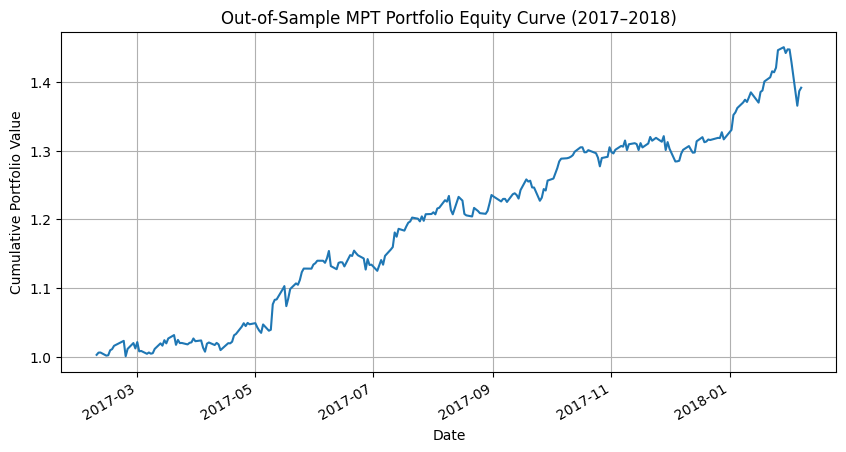

In [26]:
# -------------------------------------------------------------
# FIGURE: Out-of-sample MPT equity curve
# -------------------------------------------------------------

equity_curve = (1 + mpt_test_daily).cumprod()

ax = equity_curve.plot(
    title="Out-of-Sample MPT Portfolio Equity Curve (2017–2018)",
    figsize=(10, 5)
)
ax.set_xlabel("Date")
ax.set_ylabel("Cumulative Portfolio Value")
ax.grid(True)
plt.show()

In [27]:
# ----------------------------------------------------
# Step 11: Feature engineering for ML screening model
# ----------------------------------------------------

# Stack daily returns into long format
stacked_returns = returns.stack()
stacked_returns.index.names = ["date", "Name"]

# Initialize feature DataFrame
features = pd.DataFrame(index=stacked_returns.index)

# Rolling window lengths (in trading days)
w1, w3, w6 = 21, 63, 126

# Lagged cumulative returns (momentum)
features["ret_21d"]  = stacked_returns.groupby("Name").rolling(w1).sum().droplevel(0)
features["ret_63d"]  = stacked_returns.groupby("Name").rolling(w3).sum().droplevel(0)
features["ret_126d"] = stacked_returns.groupby("Name").rolling(w6).sum().droplevel(0)

# Lagged volatility (risk)
features["vol_21d"]  = stacked_returns.groupby("Name").rolling(w1).std().droplevel(0)
features["vol_63d"]  = stacked_returns.groupby("Name").rolling(w3).std().droplevel(0)
features["vol_126d"] = stacked_returns.groupby("Name").rolling(w6).std().droplevel(0)

# Forward 21-day return (prediction target)
features["fwd_ret_21d"] = (
    stacked_returns.groupby("Name").shift(-w1).rolling(w1).sum()
)

# Drop incomplete rolling windows
ml_data = features.dropna()

# Verify dataset size and preview
print("ML dataset shape:", ml_data.shape)
ml_data.head()

ML dataset shape: (529312, 7)


ret_21d   ret_63d  ret_126d   vol_21d   vol_63d  vol_126d  \
date       Name                                                               
2013-08-09 A     0.012034  0.063264  0.037830  0.010762  0.013423  0.014313   
           AAL   0.070357  0.054366  0.257352  0.013533  0.016191  0.020038   
           AAP   0.005707 -0.023496  0.060122  0.008750  0.010323  0.010892   
           AAPL  0.063850  0.009339 -0.028642  0.014718  0.014039  0.015758   
           ABBV  0.022568  0.002005  0.228126  0.012418  0.016682  0.017040   

                 fwd_ret_21d  
date       Name               
2013-08-09 A        0.282883  
           AAL      0.287738  
           AAP      0.295298  
           AAPL     0.258853  
           ABBV     0.254056

In [28]:
# -----------------------------------------
# Step 12: Train/test split for ML dataset
# -----------------------------------------

train_ml = ml_data.loc[
    ml_data.index.get_level_values("date") < split_date
].copy()

test_ml = ml_data.loc[
    ml_data.index.get_level_values("date") >= split_date
].copy()

print("Train ML shape:", train_ml.shape)
print("Test ML shape :", test_ml.shape)

Train ML shape: (419356, 7)
Test ML shape : (109956, 7)


In [29]:
# --------------------------------------
# Step 13: Random Forest model training
# --------------------------------------

from sklearn.ensemble import RandomForestRegressor

# Separate predictors and target
X_train = train_ml.drop(columns=["fwd_ret_21d"])
y_train = train_ml["fwd_ret_21d"]

# Initialize Random Forest with controlled complexity
rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=8,
    min_samples_leaf=50,
    random_state=42,
    n_jobs=-1
)

# Train model
rf_model.fit(X_train, y_train)

# In-sample R^2 (sanity check only)
train_r2 = rf_model.score(X_train, y_train)
print("Training R^2:", round(train_r2, 4))

Training R^2: 0.0065


In [30]:
# -------------------------------------------------------------
# Step 14: Construct ML-screened portfolio returns (TEST)
# -------------------------------------------------------------
# Purpose:
#   - Use trained ML model to rank stocks each rebalance date
#   - Select top-K stocks (equal-weight)
#   - Compute realized daily portfolio returns out-of-sample
# -------------------------------------------------------------

In [31]:
import pandas as pd

# Copy test ML dataset (features + target)
test_ml2 = test_ml.copy()

# Ensure X_test has identical columns as used during training
feature_cols = X_train.columns
X_test = test_ml2[feature_cols].copy()

# Predict forward 21-day returns (used only for ranking/screening)
test_ml2["pred_ret"] = rf_model.predict(X_test)

# Rebalance dates = first trading day of each month in the test window
test_dates = pd.DatetimeIndex(pd.to_datetime(test.index.unique())).sort_values()
rebalance_dates = (
    pd.Series(test_dates)
      .groupby(pd.Series(test_dates).dt.to_period("M"))
      .min()
      .tolist()
)

K = 30  # number of stocks selected at each rebalance

# Store daily portfolio returns
ml_port_daily = pd.Series(index=test.index, dtype=float)

for i, reb_date in enumerate(rebalance_dates):
    # Cross-sectional predictions on rebalance date
    try:
        preds_on_date = (
            test_ml2.xs(reb_date, level="date")[["pred_ret"]]
            .sort_values("pred_ret", ascending=False)
        )
    except KeyError:
        continue  # skip if no predictions exist for that date

    # Select top-K predicted stocks
    selected = preds_on_date.head(K).index.tolist()

    # Holding period: from this rebalance date to next rebalance date
    start = reb_date
    end = rebalance_dates[i + 1] if i + 1 < len(rebalance_dates) else test.index.max()

    holding_idx = test.loc[(test.index >= start) & (test.index < end)].index

    # Equal-weight realized return across selected stocks
    holding_returns = test.loc[holding_idx, selected].mean(axis=1)

    # Store portfolio returns
    ml_port_daily.loc[holding_returns.index] = holding_returns

# Drop days that did not get assigned due to skipped rebalance date(s)
ml_port_daily = ml_port_daily.dropna()

print("ML daily return series shape:", ml_port_daily.shape)
ml_port_daily.head()

ML daily return series shape: (247,)


date
2017-02-08    0.000433
2017-02-09    0.006269
2017-02-10    0.005923
2017-02-13    0.004698
2017-02-14    0.005133
dtype: float64

In [32]:
# ---------------------------------------------------------
# Step 15: Out-of-sample performance metrics (ML portfolio)
# ---------------------------------------------------------

ml_test_stats = performance_summary(ml_port_daily, rf_annual=rf_annual)
ml_test_stats

{'Annual Return': 0.11338754283191477,
 'Annual Volatility': 0.10265688264628935,
 'Sharpe Ratio': 0.9097056176319647,
 'Max Drawdown': -0.07218409979684248}

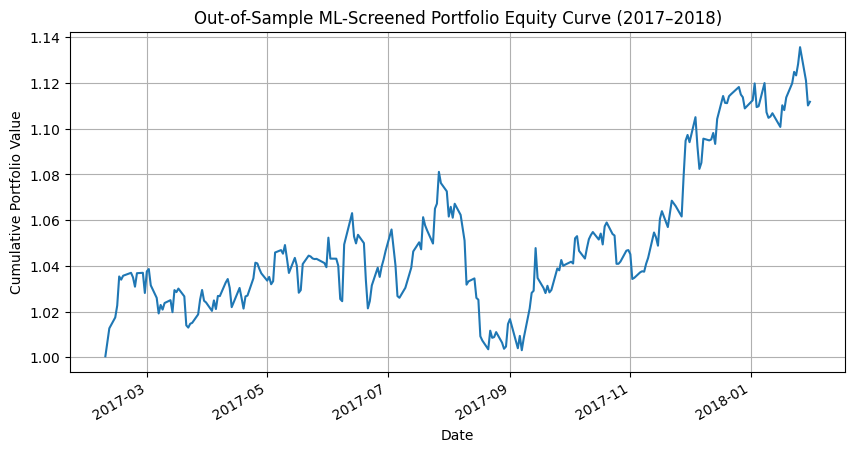

In [33]:
# -------------------------------------------------------------
# FIGURE: Out-of-sample ML portfolio equity curve
# -------------------------------------------------------------

(1 + ml_port_daily).cumprod().plot(
    title="Out-of-Sample ML-Screened Portfolio Equity Curve (2017–2018)",
    figsize=(10, 5)
)
plt.xlabel("Date")
plt.ylabel("Cumulative Portfolio Value")
plt.grid(True)
plt.show()

In [34]:
# ----------------------------------------------------------------
# Step 16 — RQ1: Side-by-side out-of-sample performance comparison
# ----------------------------------------------------------------
# Evaluates the MPT portfolio on the held-out test period, calculating realized returns and risk-adjusted metrics.

comparison_table = pd.DataFrame({
    "MPT": mpt_test_stats,
    "ML_Screened": ml_test_stats
})

comparison_table

,MPT,ML_Screened
Annual Return,0.338598,0.113388
Annual Volatility,0.126190,0.102657
Sharpe Ratio,2.524749,0.909706
Max Drawdown,-0.058747,-0.072184


In [35]:
# ----------------------------------------------
# Step 17 — RQ1: Align daily returns (MPT vs ML)
# ----------------------------------------------
# Computes the primary RQ1 evidence by comparing MPT vs. ML portfolio performance and testing differences in mean daily returns.

aligned = pd.concat(
    [mpt_test_daily.rename("MPT"),
     ml_port_daily.rename("ML")],
    axis=1,
    join="inner"
).dropna()

aligned.head(), aligned.shape

(                 MPT        ML
 date                          
 2017-02-08  0.002731  0.000433
 2017-02-09  0.003254  0.006269
 2017-02-10  0.000105  0.005923
 2017-02-13 -0.004488  0.004698
 2017-02-14  0.000552  0.005133,
 (247, 2))

In [36]:
# ---------------------------------------------------
# Step 18 — RQ1: Paired t-test on mean daily returns
# ---------------------------------------------------
# Computes the primary RQ1 evidence by comparing MPT vs. ML portfolio performance and testing differences in mean daily returns.

from scipy.stats import ttest_rel

t_stat, p_value = ttest_rel(aligned["MPT"], aligned["ML"])

print("Paired t-statistic:", t_stat)
print("p-value:", p_value)

Paired t-statistic: 1.9043139795288695
p-value: 0.05803592217067408


In [37]:
# --------------------------------------
# Research Question 2 (RQ2)
# --------------------------------------
# Focus: 
# Performs Monte Carlo simulation to estimate downside-risk measures (VaR/CVaR) and compare simulated risk to realized outcomes (RQ2).
# Do Monte Carlo simulations provide more reliable downside-risk insights than single-period optimization models?

In [38]:
# -------------------------------------------------------------
# STEP 19: Monte Carlo downside-risk simulation (MPT weights)
# -------------------------------------------------------------
# Goal:
#   Simulate 1-year portfolio outcomes using the training-period
#   mean and covariance, then compute VaR and CVaR.
# -------------------------------------------------------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)  # reproducibility

# Use training estimates (already created earlier)
mu_daily = train.mean()          # daily mean returns (vector)
cov_daily = train.cov()          # daily covariance (matrix)

# Use MPT weights aligned to train columns
w_mc = w_mpt.reindex(train.columns).fillna(0.0).values

# Sanity check: weights sum should be ~1
print("Sum of weights:", float(w_mc.sum()))

Sum of weights: 1.000000000004386


In [39]:
# ----------------------------------------------------------------------
# RQ2: Monte Carlo simulate daily returns and 1-year cumulative returns
# ----------------------------------------------------------------------
# Monte Carlo assumptions:
# - Portfolio daily returns ~ Normal(mean, variance) implied by train mu/cov
# - Simulate horizon = 252 trading days (~1 year)
# ----------------------------------------------------------------------

horizon_days = 252
n_sims = 10000
alpha = 0.05  # 95% VaR/CVaR

# Portfolio daily mean and variance implied by mu and cov
port_mu = float(np.dot(w_mc, mu_daily.values))
port_var = float(np.dot(w_mc.T, np.dot(cov_daily.values, w_mc)))
port_sigma = float(np.sqrt(port_var))

print("Implied daily mean:", port_mu)
print("Implied daily sigma:", port_sigma)

# Simulate daily portfolio returns
sim_daily = np.random.normal(loc=port_mu, scale=port_sigma, size=(n_sims, horizon_days))

# Convert to cumulative return over the horizon (compound)
sim_cum_return = (1 + sim_daily).prod(axis=1) - 1

# Compute VaR and CVaR (left tail)
var_95 = np.quantile(sim_cum_return, alpha)
cvar_95 = sim_cum_return[sim_cum_return <= var_95].mean()

rq2_mc_results = {
    "Horizon (days)": horizon_days,
    "Simulations": n_sims,
    "VaR_95 (1Y)": float(var_95),
    "CVaR_95 (1Y)": float(cvar_95),
    "Mean Sim 1Y Return": float(sim_cum_return.mean()),
    "Median Sim 1Y Return": float(np.median(sim_cum_return))
}

rq2_mc_results

Implied daily mean: 0.0016515924404946086
Implied daily sigma: 0.009441477337561718


{'Horizon (days)': 252,
 'Simulations': 10000,
 'VaR_95 (1Y)': 0.1675665820083174,
 'CVaR_95 (1Y)': 0.09865244008028841,
 'Mean Sim 1Y Return': 0.5136586144711418,
 'Median Sim 1Y Return': 0.49697903024464607}

VaR (95%):  0.1676
CVaR (95%): 0.0987


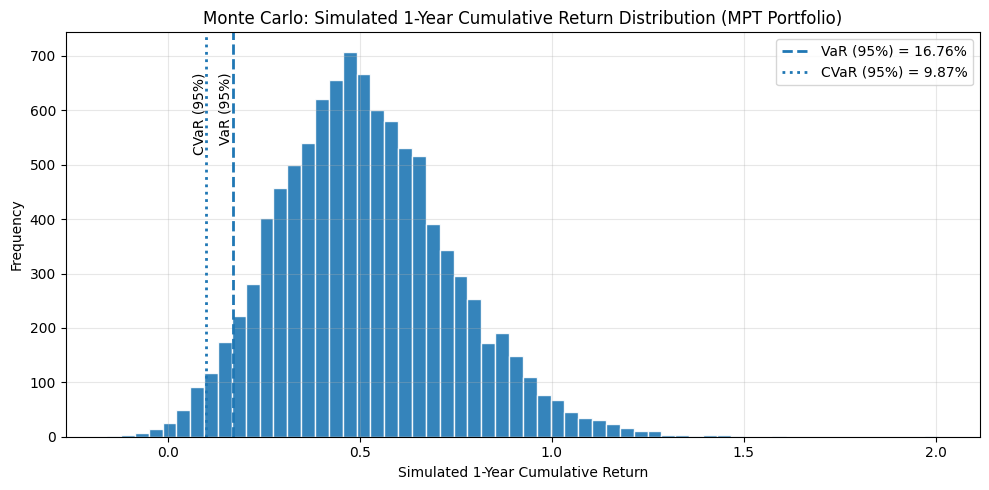

In [40]:
# -------------------------------------------------------------
# RQ2: simulated distribution
# -------------------------------------------------------------
# FIGURE: Distribution of simulated 1-year cumulative returns
# -------------------------------------------------------------

# --- 1) Compute VaR and CVaR (95%) from simulated 1-year cumulative returns ---
alpha = 0.95

var_95 = np.percentile(sim_cum_return, (1 - alpha) * 100)  # 5th percentile
cvar_95 = sim_cum_return[sim_cum_return <= var_95].mean()

print(f"VaR (95%):  {var_95:.4f}")
print(f"CVaR (95%): {cvar_95:.4f}")

# --- 2) Plot histogram ---
plt.figure(figsize=(10, 5))
plt.hist(sim_cum_return, bins=60, edgecolor="white", alpha=0.9)

plt.title("Monte Carlo: Simulated 1-Year Cumulative Return Distribution (MPT Portfolio)")
plt.xlabel("Simulated 1-Year Cumulative Return")
plt.ylabel("Frequency")
plt.grid(True, alpha=0.3)

# --- 3) Add VaR and CVaR vertical lines ---
plt.axvline(var_95, linestyle="--", linewidth=2, label=f"VaR (95%) = {var_95:.2%}")
plt.axvline(cvar_95, linestyle=":", linewidth=2, label=f"CVaR (95%) = {cvar_95:.2%}")

# --- 4) Add optional text annotations near the lines ---
ymax = plt.ylim()[1]
plt.text(var_95, ymax * 0.9, "VaR (95%)", rotation=90, va="top", ha="right")
plt.text(cvar_95, ymax * 0.9, "CVaR (95%)", rotation=90, va="top", ha="right")

# --- 5) Legend ---
plt.legend(loc="upper right")

plt.tight_layout()
plt.show()

In [41]:
# --------------------------------------------------------------------------------
# Step 20 — RQ2: Compare Monte Carlo simulated downside risk to realized downside
# --------------------------------------------------------------------------------

# Realized downside from MPT out-of-sample results
realized_max_dd = mpt_test_stats["Max Drawdown"]  # negative value

rq2_compare = pd.DataFrame({
    "Monte Carlo (Train-based, 1Y)": [var_95, cvar_95],
    "Realized (Test period)": [realized_max_dd, realized_max_dd]
}, index=["VaR_95", "CVaR_95 / MaxDD proxy"])

rq2_compare

,"Monte Carlo (Train-based, 1Y)",Realized (Test period)
VaR_95,0.167567,-0.058747
CVaR_95 / MaxDD proxy,0.098652,-0.058747


In [42]:
# RQ3 — Volatility Regime Analysis
# Define regimes (terciles)
# Defines volatility regimes (using VIX or return-based terciles) and evaluates model performance across regimes to address RQ3.

In [43]:
# -----------------------------------------------------
# Step 21 — RQ3: Download VIX cleanly and label regimes
# -----------------------------------------------------

import yfinance as yf
import pandas as pd
import numpy as np

# 1) Download VIX (explicit auto_adjust to remove FutureWarning)
vix_raw = yf.download(
    "^VIX",
    start=returns.index.min(),
    end=returns.index.max() + pd.Timedelta(days=1),
    auto_adjust=False,
    progress=False
)

# 2) Extract a clean numeric VIX close series (handles MultiIndex columns safely)
# If yfinance returns MultiIndex columns like ('Close','^VIX'), this will flatten them.
if isinstance(vix_raw.columns, pd.MultiIndex):
    vix_raw.columns = vix_raw.columns.get_level_values(0)

vix = vix_raw[["Close"]].rename(columns={"Close": "vix"}).copy()
vix.index = pd.to_datetime(vix.index)

# 3) Align to your returns trading days and coerce to numeric
vix = vix.reindex(returns.index).ffill()
vix["vix"] = pd.to_numeric(vix["vix"], errors="coerce")

# Safety: drop any remaining missing values (should be minimal after ffill)
vix = vix.dropna(subset=["vix"])

# 4) Compute tercile cutoffs as scalar floats (no Series objects)
q1 = float(vix["vix"].quantile(0.33))
q2 = float(vix["vix"].quantile(0.66))

print("VIX terciles: q1 =", q1, "| q2 =", q2)

# 5) Label regimes (vectorized; avoids apply() issues)
vix["regime"] = np.select(
    [vix["vix"] <= q1, vix["vix"] <= q2],
    ["Low", "Medium"],
    default="High"
)

# Evidence outputs
display(vix.head())
vix["regime"].value_counts()

VIX terciles: q1 = 12.65809980392456 | q2 = 14.680000305175781


Price,vix,regime
date,,
2013-02-11,12.94,Medium
2013-02-12,12.64,Low
2013-02-13,12.98,Medium
2013-02-14,12.66,Medium
2013-02-15,12.46,Low


regime
High      427
Medium    416
Low       415
Name: count, dtype: int64

In [44]:
# --------------------------------------------------------------------
# Step 22 — RQ3: Attach regime labels to TEST-period portfolio returns
# --------------------------------------------------------------------
# Defines volatility regimes (using VIX or return-based terciles) and evaluates model performance across regimes to address RQ3.

# Join regime label to each portfolio's TEST-period daily return series
mpt_test_reg = pd.concat(
    [mpt_test_daily.rename("mpt"),
     vix.loc[mpt_test_daily.index, "regime"]],
    axis=1
).dropna()

ml_test_reg = pd.concat(
    [ml_port_daily.rename("ml"),
     vix.loc[ml_port_daily.index, "regime"]],
    axis=1
).dropna()

print("MPT regime rows:", mpt_test_reg.shape)
print("ML regime rows :", ml_test_reg.shape)

mpt_test_reg.head()

MPT regime rows: (252, 2)
ML regime rows : (247, 2)


,mpt,regime
date,,
2017-02-08,0.002731,Low
2017-02-09,0.003254,Low
2017-02-10,0.000105,Low
2017-02-13,-0.004488,Low
2017-02-14,0.000552,Low


In [45]:
# ---------------------------------------------------------------
# Step 23 — RQ3: Compute performance metrics by volatility regime
# ---------------------------------------------------------------
# Defines volatility regimes (using VIX or return-based terciles) and evaluates model performance across regimes to address RQ3.

def perf_by_regime(df, return_col, rf=rf_annual):
    out = {}
    for r in ["Low", "Medium", "High"]:
        sub = df.loc[df["regime"] == r, return_col]
        out[r] = performance_summary(sub, rf_annual=rf)
    return pd.DataFrame(out).T

# Performance by regime
mpt_reg_stats = perf_by_regime(mpt_test_reg, "mpt")
ml_reg_stats  = perf_by_regime(ml_test_reg,  "ml")

print("MPT performance by regime:")
display(mpt_reg_stats)

print("\nML performance by regime:")
display(ml_reg_stats)

MPT performance by regime:


,Annual Return,Annual Volatility,Sharpe Ratio,Max Drawdown
Low,0.497279,0.113084,4.220586,-0.027936
Medium,0.214844,0.088504,2.201545,-0.011994
High,-2.187639,0.241176,-9.153626,-0.127887



ML performance by regime:


,Annual Return,Annual Volatility,Sharpe Ratio,Max Drawdown
Low,0.222434,0.100509,2.014092,-0.039184
Medium,-0.225106,0.081545,-3.005757,-0.021866
High,-1.924928,0.110159,-17.655642,-0.068201


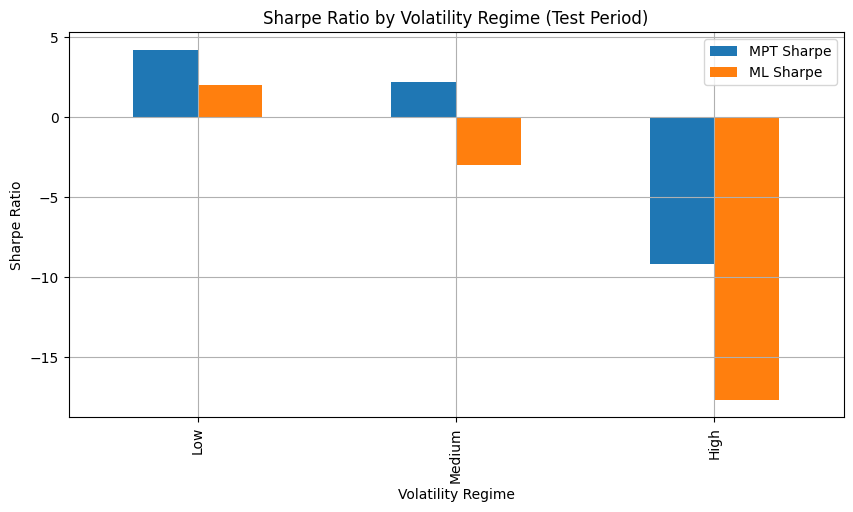

,MPT Sharpe,ML Sharpe
Low,4.220586,2.014092
Medium,2.201545,-3.005757
High,-9.153626,-17.655642


In [46]:
# -------------------------------------------------------
# Step 24 RQ3: Visual comparison — Sharpe ratio by regime
# -------------------------------------------------------

compare_sharpe = pd.DataFrame({
    "MPT Sharpe": mpt_reg_stats["Sharpe Ratio"],
    "ML Sharpe":  ml_reg_stats["Sharpe Ratio"]
})

compare_sharpe.plot(
    kind="bar",
    figsize=(10,5),
    title="Sharpe Ratio by Volatility Regime (Test Period)"
)
plt.xlabel("Volatility Regime")
plt.ylabel("Sharpe Ratio")
plt.grid(True)
plt.show()

compare_sharpe

In [47]:
# ===============================================================
# Appendix A — Data Export for PostgreSQL Integration 

# ---------------------------------------------------------------
# create the PostgreSQL database-ready versions
# ===============================================================

# Create tidy (SQL-ready) dataframes

# prices_daily (long format)
prices_daily = (
    prices
    .reset_index()
    .melt(id_vars="date", var_name="ticker", value_name="close_price")
    .rename(columns={"date": "trade_date"})
)

prices_daily.head()
prices_daily.columns

Index(['trade_date', 'ticker', 'close_price'], dtype='object')

In [48]:
# returns_daily 
returns_daily = (
    returns
    .reset_index()
    .melt(id_vars="date", var_name="ticker", value_name="daily_return")
    .rename(columns={"date": "trade_date"})
)

returns_daily.head()
returns_daily.columns

Index(['trade_date', 'ticker', 'daily_return'], dtype='object')

In [49]:
# portfolio_weights

# weights exist as Series (w_mpt, ML weights are implicit).
portfolio_weights = (
    w_mpt
    .reset_index()
    .rename(columns={"index": "ticker", 0: "weight"})
)

portfolio_weights["method"] = "MPT"
portfolio_weights["rebalance_date"] = train.index.max()

portfolio_weights = portfolio_weights[
    ["method", "rebalance_date", "ticker", "weight"]
]

portfolio_weights.columns

Index(['method', 'rebalance_date', 'ticker', 'weight'], dtype='object')

In [50]:
# portfolio_performance
# This already exists as:
# mpt_test_daily
# ml_port_daily

portfolio_performance = (
    pd.concat([
        mpt_test_daily.rename("portfolio_return").to_frame().assign(method="MPT"),
        ml_port_daily.rename("portfolio_return").to_frame().assign(method="ML")
    ])
    .reset_index()
    .rename(columns={"index": "trade_date"})
)

portfolio_performance["cum_return"] = (
    portfolio_performance
    .groupby("method")["portfolio_return"]
    .transform(lambda x: (1 + x).cumprod() - 1)
)

portfolio_performance.columns

Index(['date', 'portfolio_return', 'method', 'cum_return'], dtype='object')

In [51]:
# risk_metrics
# This already exists conceptually as:
# mpt_test_stats
# ml_test_stats

risk_metrics = (
    pd.DataFrame({
        "MPT": mpt_test_stats,
        "ML": ml_test_stats
    })
    .reset_index()
    .rename(columns={"index": "metric"})
    .melt(id_vars="metric", var_name="method", value_name="value")
)

risk_metrics.columns

Index(['metric', 'method', 'value'], dtype='object')

In [52]:
# volatility_regimes

volatility_regimes = vix.copy()
volatility_regimes["regime"] = pd.qcut(
    volatility_regimes["vix"],
    q=3,
    labels=["Low", "Medium", "High"]
)

volatility_regimes = (
    volatility_regimes
    .reset_index()
    .rename(columns={"index": "trade_date"})
)

volatility_regimes.columns

Index(['date', 'vix', 'regime'], dtype='object', name='Price')

In [53]:
# ---------------------------------------------------------------
# Data Export for PostgreSQL Integration
# ---------------------------------------------------------------

# Export to CSV (PostgreSQL ingestion-ready)

from pathlib import Path

EXPORT_DIR = Path.cwd() / "capstone_exports"
EXPORT_DIR.mkdir(parents=True, exist_ok=True)  # <-- creates folder if missing

prices_daily.to_csv(EXPORT_DIR / "prices_daily.csv", index=False)
returns_daily.to_csv(EXPORT_DIR / "returns_daily.csv", index=False)
portfolio_weights.to_csv(EXPORT_DIR / "portfolio_weights.csv", index=False)
portfolio_performance.to_csv(EXPORT_DIR / "portfolio_performance.csv", index=False)
risk_metrics.to_csv(EXPORT_DIR / "risk_metrics.csv", index=False)
volatility_regimes.to_csv(EXPORT_DIR / "volatility_regimes.csv", index=False)

print("Exported to: ./capstone_exports")

Exported to: ./capstone_exports
